In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy


# Create a list with the filepaths for training and testing
train_dir = Path('./work/train')
train_filepaths = list(train_dir.glob('**/*.jpg')) + list(train_dir.glob('**/*.jpeg'))

test_dir = Path('./work/test')
test_filepaths = list(test_dir.glob('**/*.jpg')) + list(test_dir.glob('**/*.jpeg'))

val_dir = Path('./work/validation')
val_filepaths = list(val_dir.glob('**/*.jpg')) + list(val_dir.glob('**/*.jpeg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [path.parent.name for path in filepath]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [2]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1192

Number of different labels: 15

Labels: ['watermelon' 'lemon' 'orange' 'pineapple' 'tomato' 'kiwi' 'pomegranate'
 'apple' 'mango' 'pear' 'strawberries' 'avocado' 'grapes' 'cherry'
 'banana']


In [3]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(15)

,Filepath,Label
0,work\train\watermelon\Image_34.jpg,watermelon
1,work\train\lemon\Image_54.jpg,lemon
2,work\train\orange\Image_63.jpg,orange
3,work\train\pineapple\Image_81.jpg,pineapple
4,work\train\tomato\Image_2.jpg,tomato
5,work\train\kiwi\Image_7.jpg,kiwi
6,work\train\pomegranate\Image_61.jpg,pomegranate
7,work\train\orange\Image_36.jpg,orange
8,work\train\apple\Image_45.jpg,apple
9,work\train\watermelon\Image_58.jpg,watermelon


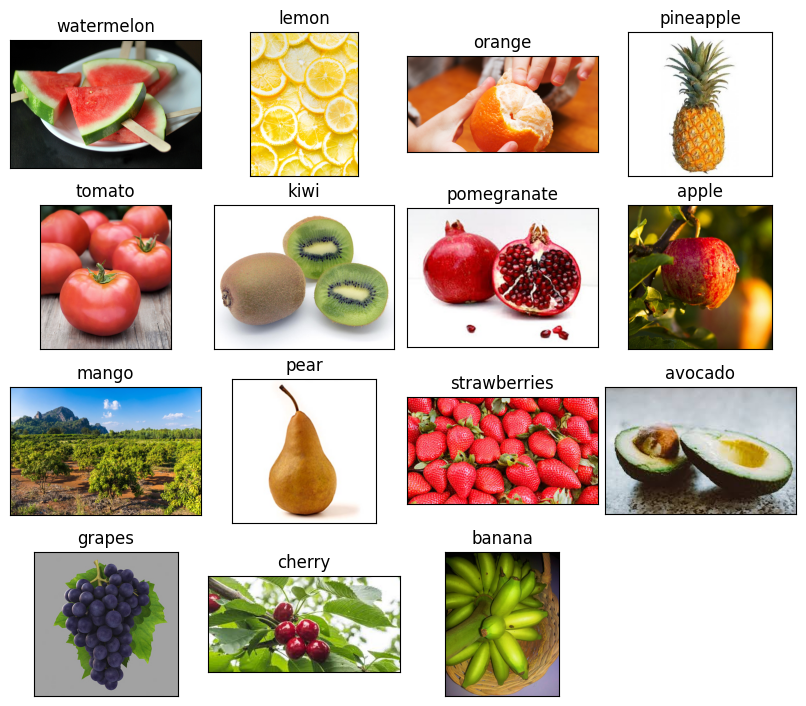

In [4]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Calculate the number of rows and columns based on the number of unique labels
num_labels = len(df_unique)
num_rows = int(np.ceil(np.sqrt(num_labels)))
num_cols = int(np.ceil(num_labels / num_rows))

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_labels:
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis("off")  # Turn off empty subplots if there are more slots than labels

plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=45, 
    zoom_range=0.3,     
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=45, 
    zoom_range=0.3,     
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1192 validated image filenames belonging to 15 classes.
Found 145 validated image filenames belonging to 15 classes.
Found 148 validated image filenames belonging to 15 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# Fine-tuning
pretrained_model.trainable = True
fine_tune_at = -10
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
num_classes = 15

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Change the number of units to match the number of classes
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create an optimizer with a specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizer,  # Use the specified optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate schedule
def lr_schedule(epoch):
    if epoch < 3:
        return 0.001
    elif 3 <= epoch < 7:
        return 0.0001
    else:
        return 0.00001

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=50,  # Increase the number of epochs
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,  # Adjust patience as needed
            restore_best_weights=True
        ),
        lr_callback
    ]
)

Epoch 1/50
 4/38 [==>...........................] - ETA: 19s - loss: 6.0530 - accuracy: 0.2109

In [8]:
model.save("my_model.h5")

C:\Users\cyber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 601ms/step


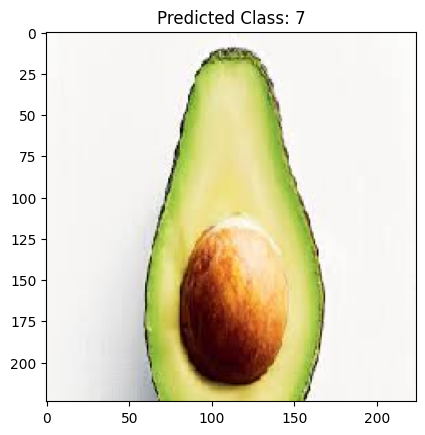

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the number of classes based on the fruit categories in your dataset
num_classes = 15

# Load and preprocess your own image
img_path = "./apple.jpg"  # Change this to the path of your fruit image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Load your trained fruit classification model
loaded_model = tf.keras.models.load_model("./fruit_model.h5")

# Make predictions
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Display the input image along with the model's prediction
plt.imshow(img)
plt.title(f"Predicted Fruit Class: {predicted_class}")
plt.show()

In [10]:
print(tf.__version__)

2.14.0
